# Chapter 3 - Linear Regression

- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

In [64]:
using BenchmarkTools
using DataFrames
using DelimitedFiles
using CSV
using Plots
using GLM


### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [6]:
advertising = CSV.read("Data/Advertising.csv", DataFrame, select=[2,3,4,5])
describe(advertising)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,TV,147.043,0.7,149.75,296.4,,,Float64
2,Radio,23.264,0.0,22.9,49.6,,,Float64
3,Newspaper,30.554,0.3,25.75,114.0,,,Float64
4,Sales,14.0225,1.6,12.9,27.0,,,Float64


In [24]:
print(range(1,step=1,stop=12))

1:1:12

In [59]:
credit = CSV.read("Data/Credit.csv", DataFrame, select=collect(2:13))
function f(x)
    x = (x == "Yes" ? 1 : 0);
end
credit.Student2 = f.(credit.Student)
first(credit, 3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity
,Float64,Int64,Int64,Int64,Int64,Int64,String,String,String,String
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian
3,104.593,7075,514,4,71,11,Male,No,No,Asian


In [63]:
auto = dropmissing(CSV.read("Data/Auto.csv", DataFrame))
describe(auto)

,variable,mean,min,median,max,nunique
,Symbol,Union…,Any,Union…,Any,Union…
1,mpg,23.5159,9.0,23.0,46.6,
2,cylinders,5.45844,3,4.0,8,
3,displacement,193.533,68.0,146.0,455.0,
4,horsepower,,100,,?,94
5,weight,2970.26,1613,2800.0,5140,
6,acceleration,15.5557,8.0,15.5,24.8,
7,year,75.995,70,76.0,82,
8,origin,1.57431,1,1.0,3,
9,name,,amc ambassador brougham,,vw rabbit custom,304


## 3.1 Simple Linear Regression

### Figure 3.1 - Least Squares Fit

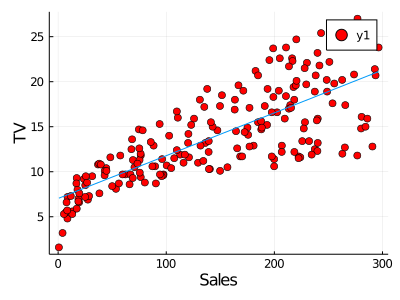

In [87]:
scatter(advertising.TV, advertising.Sales, markercolor=:red, smooth=true, size=(400,300))
xlabel!("Sales")
ylabel!("TV")

### Figure 3.2 - Regression coefficients - RSS
The Data has been centered before calculating the coefficients.
We use the GLM package for fitting. 
More info: https://juliastats.org/GLM.jl/latest/examples/

In [93]:
# Regression coefficients (Ordinary Least Squares)
advertising.TV = advertising.TV .- mean(advertising.TV)
ols = lm(@formula(Sales ~ TV), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Sales ~ 1 + TV

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  14.0225     0.230422    60.86    <1e-99  13.5681     14.4769
TV            0.0475366  0.00269061  17.67    <1e-41   0.0422307   0.0528426
────────────────────────────────────────────────────────────────────────────

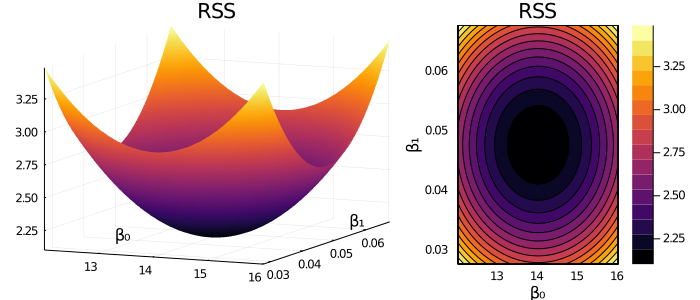

In [262]:
X = advertising.TV
Y = advertising.Sales

B0 = collect(range(coef(ols)[1] -2, coef(ols)[1] + 2 ; length=50))
B1 = collect(range(coef(ols)[2] -0.02, coef(ols)[2] + 0.02 ; length=50))

function RSS(x,y)
    sum((Y .- x .- X.*y).^2)/1000
end
Z = RSS.(B0,B1')

l = @layout [a{0.6w} b]
p1 = plot(B0 , B1 , Z , st = :surface)
p2 = plot(B0 , B1 , Z , st = :contourf, legend=true)
p = plot(p1,p2, layout=l, size=(700,300))
xlabel!("β₀")
ylabel!("β₁")
title!("RSS")

### Confidence interval on Page 67 and Table 3.1 & 3.2

In [269]:
advertising = CSV.read("Data/Advertising.csv", DataFrame, select=[2,3,4,5])
ols = lm(@formula(Sales ~ TV), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Sales ~ 1 + TV

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  7.03259    0.457843    15.36    <1e-34  6.12972    7.93547
TV           0.0475366  0.00269061  17.67    <1e-41  0.0422307  0.0528426
─────────────────────────────────────────────────────────────────────────

In [270]:
# RSS with regression coefficients
sum((advertising.Sales .- coef(ols)[1] .- advertising.TV.*coef(ols)[2]).^2)/1000

2.1025305831313523

In [280]:
#Also can be calculated in the following manner
println("RSS: ",deviance(ols)/1000)

RSS: 2.1025305831313523


In [278]:
#R2 Score of the regression
println("R² Score: ", r2(ols))

R² Score: 0.6118750508500708


## 3.2 Multiple Linear Regression

In [281]:
est = lm(@formula(Sales ~ Radio), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Sales ~ 1 + Radio

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  9.31164    0.5629     16.54    <1e-38   8.20159   10.4217
Radio        0.202496   0.0204113   9.92    <1e-18   0.162244   0.242747
────────────────────────────────────────────────────────────────────────

In [285]:
est = lm(@formula(Sales ~ Newspaper), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Sales ~ 1 + Newspaper

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  12.3514      0.62142    19.88    <1e-48  11.126      13.5769
Newspaper     0.0546931   0.0165757   3.30    0.0011   0.0220055   0.0873807
────────────────────────────────────────────────────────────────────────────

In [286]:
est = lm(@formula(Sales ~ TV + Radio + Newspaper), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Sales ~ 1 + TV + Radio + Newspaper

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   2.93889     0.311908     9.42    <1e-16   2.32376    3.55402
TV            0.0457646   0.0013949   32.81    <1e-80   0.0430137  0.0485156
Radio         0.18853     0.00861123  21.89    <1e-53   0.171547   0.205513
Newspaper    -0.00103749  0.00587101  -0.18    0.8599  -0.012616   0.010541
────────────────────────────────────────────────────────────────────────────

### Table 3.5 Correlation Matrix

In [386]:
df = advertising
DataFrame([cor(x, y) for x=eachcol(df), y=eachcol(df)], names(df))

,TV,Radio,Newspaper,Sales
,Float64,Float64,Float64,Float64
1,1.0,0.0548087,0.0566479,0.782224
2,0.0548087,1.0,0.354104,0.576223
3,0.0566479,0.354104,1.0,0.228299
4,0.782224,0.576223,0.228299,1.0


### Figure 3.5 - Multiple Linear Regression

In [387]:
est = lm(@formula(Sales ~ TV + Radio), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Sales ~ 1 + TV + Radio

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  2.9211     0.29449      9.92    <1e-18  2.34034    3.50186
TV           0.0457548  0.00139036  32.91    <1e-81  0.0430129  0.0484967
Radio        0.187994   0.00803997  23.38    <1e-58  0.172139   0.20385
─────────────────────────────────────────────────────────────────────────

┌ Info: Saved animation to 
│   fn = G:\ISLR-Julia\Notebooks\tmp.gif
└ @ Plots C:\Users\saswa\.julia\packages\Plots\uCh2y\src\animation.jl:104


Plots.AnimatedGif("G:\\ISLR-Julia\\Notebooks\\tmp.gif")
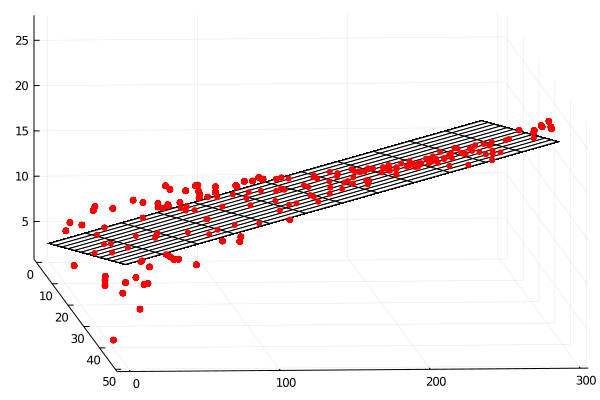

In [486]:
# Create the Plot
Radio = collect(range(0,49;step=4))
TV = collect(range(0,299;step=24))

function pl(x,y)
    coef(est)[1] + x*coef(est)[3] + y*coef(est)[2]
end
Z = pl.(Radio, TV')
@gif for i in range(0, stop = 2π, length = 60)
    plot!(Radio, TV, pl,st=:wireframe, camera=(40 * (1 + cos(i)), 40))
    scatter3d!(advertising.Radio, advertising.TV, advertising.Sales, markercolor=:red, markerstrokewidth=0)
end

In [476]:
?save

search: savefig StackOverflowError AbstractVector AbstractVecOrMat iscatvalue

Couldn't find save
Perhaps you meant size, Base, savefig, isa, Shape, stack, stat, zscale or std


No documentation found.

Binding `save` does not exist.


In [326]:
describe(advertising)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,TV,147.043,0.7,149.75,296.4,,,Float64
2,Radio,23.264,0.0,22.9,49.6,,,Float64
3,Newspaper,30.554,0.3,25.75,114.0,,,Float64
4,Sales,14.0225,1.6,12.9,27.0,,,Float64


In [328]:
μ = [mean(eachcol(advertising)[i]) for i in 1:4]

4-element Array{Float64,1}:
 147.04250000000002
  23.264000000000006
  30.554000000000002
  14.0225

In [352]:
Matrix(advertising .- μ')' * Matrix(advertising .- μ')

4×4 Array{Float64,2}:
     1.46682e6  13902.6  21078.0   69727.6
 13902.6        43865.1  22784.9    8882.5
 21078.0        22784.9  94387.4    5162.34
 69727.6         8882.5   5162.34   5417.15

In [353]:
size(Matrix(advertising .- μ')')

(4, 200)

In [354]:
[corna(x[2], y[2]) for x=eachcol(advertising), y=eachcol(advertising)]

UndefVarError: UndefVarError: corna not defined

In [357]:
using Statistics
?corna

LoadError: syntax: invalid identifier name "?"

In [358]:
?corna

search: Colorant ColorantNormed @colorant_str base_colorant_type code_warntype

Couldn't find corna
Perhaps you meant cor, conj, count, Core, coords, color, cov, coef or comp1


No documentation found.

Binding `corna` does not exist.


In [363]:
function corna(x, y)
    b = !(isna(x) | isna(y))
    cor(x, y)
end

import Base.cor
import Statistics.cor
function cor(df::AbstractDataFrame)
    [corna(x[2], y[2]) for x=eachcol(df), y=eachcol(df)]
end
cor(advertising)

UndefVarError: UndefVarError: isna not defined

In [374]:
df = advertising
[cor(eachcol(df)[x], eachcol(df)[y]) for x=eachcol(df), y=eachcol(df)]

4×4 Array{Float64,2}:
 1.0        0.0548087  0.0566479  0.782224
 0.0548087  1.0        0.354104   0.576223
 0.0566479  0.354104   1.0        0.228299
 0.782224   0.576223   0.228299   1.0

In [379]:
[cor(x, y) for x=eachcol(df), y=eachcol(df)]

4×4 Array{Float64,2}:
 1.0        0.0548087  0.0566479  0.782224
 0.0548087  1.0        0.354104   0.576223
 0.0566479  0.354104   1.0        0.228299
 0.782224   0.576223   0.228299   1.0